# NOD risk

From Sharma et al we have:
- NOD 3y risk = 0.9%<br>
- Avg risk = 0.11%

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from csaps import csaps

In [ ]:
seer_inc = pd.read_csv("../data/seer_incidence_1y.csv")
seer_inc.iloc[:5]

In [40]:
risk_1y_NOD = 1-(1-0.036)**(1/3)
risk_1y_avg = 1-(1-0.0011)**(1/3)
ratio = risk_1y_NOD / risk_1y_avg
print(f"Literature ratio (3.6% vs 0.11%): {round(ratio,2)}")

Literature ratio (3.6% vs 0.11%): 33.12


Find comparable 3-y incidence group, and identify appropriate weights to increase incidence by, with higher risk ratio in 1st year and decreasing to 3rd year:

In [47]:
avg_risks = seer_inc.query('Age > 71 & Age < 75')['LRDU Rate']
print(f"Incidence ages 72-74: {[round(risk,2) for risk in avg_risks]}")
print(f"Average risk for 72-74 = { round((sum(avg_risks) / 100000) * 100, 3)}%")
risk_ratios = [35, 33, 28]
risks_nod = [ratio * risk for ratio, risk in zip(risk_ratios, avg_risks)]
print(f"New incidences: {[round(risk,2) for risk in risks_nod]}")
print(f"New risk: {round((sum(risks_nod)/ 100000) * 100, 3)}%")

Incidence ages 72-74: [35.29, 37.85, 39.72]
Average risk for 72-74 = 0.113%
New incidences: [1235.02, 1249.09, 1112.3]
New risk: 3.596%


Apply above risk ratios to 60, 61, 62 y/o population:

In [48]:
avg_risks =  seer_inc.query('Age > 59 & Age < 63')['LRDU Rate']
risks_nod = [ratio * risk for ratio, risk in zip(risk_ratios, avg_risks)]
print(f"Incidence ages 60-62: {[round(risk,2) for risk in avg_risks]}")
print(f"Average risk for 60-62 = { round((sum(avg_risks) / 100000) * 100, 3)}%")
print(f"New incidences: {[round(risk,2) for risk in risks_nod]}")
print(f"New risk: {round((sum(risks_nod)/ 100000) * 100, 3)}%")

Incidence ages 60-62: [15.67, 16.97, 18.83]
Average risk for 60-62 = 0.051%
New incidences: [548.49, 559.88, 527.23]
New risk: 1.636%


Implement smoothing to not have too irregular increase, while fitting the points:

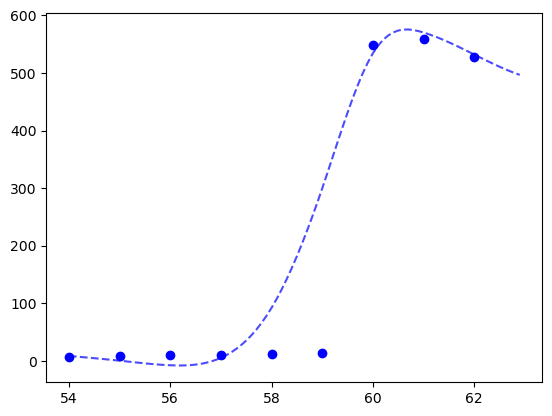

In [66]:
risks_55_62 = np.append(seer_inc.query('Age > 53 & Age < 60')['LRDU Rate'].to_numpy(), risks_nod)
risks_55_62
ages = np.arange(54,63,1)
ages_fin = np.arange(54,63,0.1)
weights = [1, 1, 1,1,0.7, 0.5, 20, 10, 3] 
smooth_risks = csaps(ages, risks_55_62, weights=weights, smooth=0.7, axis=0)(ages_fin)
plt.plot(ages_fin, smooth_risks, linestyle='--', alpha=0.7, color='blue', label='Smoothed spline')
plt.scatter(ages, risks_55_62, color='blue', label='Original data')

In [67]:
new_risks_57_62 = csaps(ages, risks_55_62, weights=weights, smooth=0.7, axis=0)(np.arange(57,63,1))
nod_df = seer_inc.query('Age > 56 & Age < 63').copy()
nod_df['LRDU Rate'] = new_risks_57_62
nod_df['LocalU'] = nod_df['pLocal'] * nod_df['LRDU Rate']
nod_df['RegionalU'] = nod_df['pRegional'] * nod_df['LRDU Rate']
nod_df['DistantU'] = nod_df['pDistant'] * nod_df['LRDU Rate']

In [68]:
nod_df

,Unnamed: 0,Distant Rate,Localized Rate,Regional Rate,Unknown/unstaged Rate,Age,LRD Rate,LRDU Rate,pLocal,pRegional,pDistant,LocalU,RegionalU,DistantU
37,57,6.630113,0.737185,3.321882,0.268481,57,10.689180,5.487884,0.068966,0.310771,0.620264,0.378475,1.705473,3.403937
38,58,7.783539,0.790991,3.753697,0.341671,58,12.328227,92.270571,0.064161,0.304480,0.631359,5.920169,28.094532,58.255870
39,59,8.484898,1.060004,4.249743,0.379268,59,13.794645,299.624578,0.076842,0.308072,0.615086,23.023663,92.305924,184.294992
40,60,9.761491,1.036619,4.471688,0.401436,60,15.269798,534.167447,0.067887,0.292845,0.639268,36.262963,156.428406,341.476078
41,61,10.218427,1.043339,5.195721,0.508562,61,16.457487,570.252909,0.063396,0.315706,0.620898,36.151759,180.032043,354.069107
42,62,11.536792,1.172771,5.662029,0.458199,62,18.371592,532.079603,0.063836,0.308195,0.627969,33.965893,163.984163,334.129547


In [69]:
nod_df.drop(['Unnamed: 0', 'Distant Rate', 'Localized Rate', 'Regional Rate', 'Unknown/unstaged Rate', 'LRD Rate'], axis=1, inplace=True)

In [70]:
nod_df.to_csv("../data/seer_incidence_nod.csv")

In [71]:
# # Calculate new risks for ages 57-62
# new_risks_57_62 = csaps(ages, risks_55_62, weights=weights, smooth=0.7, axis=0)(np.arange(57, 63, 1))

# # Modify rows for ages 57-62
# nod_df = seer_inc.query('Age > 56 & Age < 63').copy()
# nod_df['LRDU Rate'] = new_risks_57_62
# nod_df['LocalU'] = nod_df['pLocal'] * nod_df['LRDU Rate']
# nod_df['RegionalU'] = nod_df['pRegional'] * nod_df['LRDU Rate']
# nod_df['DistantU'] = nod_df['pDistant'] * nod_df['LRDU Rate']

# Original data for ages 20-56
original_df = seer_inc.query('Age <= 56').copy()

# Combine original (20-56) and modified (57-62)
combined_df = pd.concat([original_df, nod_df], axis=0).sort_values(by='Age').reset_index(drop=True)

# Output combined dataframe
print(combined_df)

    Unnamed: 0  Distant Rate  Localized Rate  Regional Rate  \
0         20.0      0.015638        0.066462       0.003910   
1         21.0      0.003894        0.054513       0.007788   
2         22.0      0.015596        0.046787       0.000000   
3         23.0      0.003888        0.054429       0.019439   
4         24.0      0.015566        0.035022       0.011674   
5         25.0      0.019438        0.046651       0.003888   
6         26.0      0.031312        0.050881       0.023484   
7         27.0      0.011750        0.043084       0.007833   
8         28.0      0.031462        0.043260       0.031462   
9         29.0      0.043481        0.055339       0.043481   
10        30.0      0.086206        0.043103       0.031348   
11        31.0      0.059258        0.079010       0.027654   
12        32.0      0.102512        0.039428       0.078856   
13        33.0      0.106799        0.090977       0.055377   
14        34.0      0.134689        0.035653       0.07

In [72]:
print(combined_df.query('Age > 56 & Age < 63'))  # Check modified rows
print(combined_df.query('Age <= 56'))  # Check original rows

    Unnamed: 0  Distant Rate  Localized Rate  Regional Rate  \
37         NaN           NaN             NaN            NaN   
38         NaN           NaN             NaN            NaN   
39         NaN           NaN             NaN            NaN   
40         NaN           NaN             NaN            NaN   
41         NaN           NaN             NaN            NaN   
42         NaN           NaN             NaN            NaN   

    Unknown/unstaged Rate  Age  LRD Rate   LRDU Rate    pLocal  pRegional  \
37                    NaN   57       NaN    5.487884  0.068966   0.310771   
38                    NaN   58       NaN   92.270571  0.064161   0.304480   
39                    NaN   59       NaN  299.624578  0.076842   0.308072   
40                    NaN   60       NaN  534.167447  0.067887   0.292845   
41                    NaN   61       NaN  570.252909  0.063396   0.315706   
42                    NaN   62       NaN  532.079603  0.063836   0.308195   

    pDistant     L

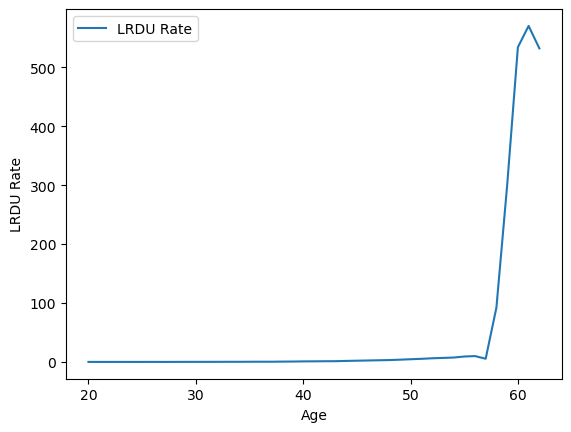

In [74]:
import matplotlib.pyplot as plt

plt.plot(combined_df['Age'], combined_df['LRDU Rate'], label='LRDU Rate')
plt.xlabel('Age')
plt.ylabel('LRDU Rate')
plt.legend()
plt.show()


In [75]:
combined_df.to_csv("../data/seer_incidence_nod_full.csv")